In [1]:
import pandas as pd

import numpy as np
from geopandas import sjoin

from scipy.stats.qmc import PoissonDisk
from shapely import Point, Polygon, MultiPolygon
import geopandas as gpd


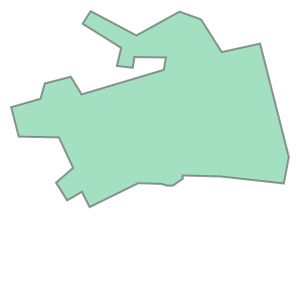

In [2]:

local_crs = 32636
border: Polygon = gpd.read_file('Аэродром Сиверск .geojson').to_crs(local_crs).union_all()
areas_dict = {'industrial': 0.2,
              'residential': 0.5,
              'recreation': 0.1,
              'business': 0.1,
              'agro':0.1}
border

In [ ]:
from gen_planner.python.src.genplanner import GenPlanner
from shapely.ops import unary_union
gp = GenPlanner(gpd.read_file('shlis.gpkg'))
p = gp._generate_blocks(border)
unary_union([p.exterior,p.buffer(0.02).exterior])

In [4]:
from shapely.geometry import Polygon
import math
from typing import List, Tuple

def rectangle_angle(rect: Polygon) -> tuple:
    if not isinstance(rect, Polygon) or len(rect.exterior.coords) != 5:
        raise ValueError("Переданный объект не является прямоугольником.")
    coords = list(rect.exterior.coords)[:-1]
    sides = [(coords[0], coords[1]),(coords[1], coords[2])]
        
    lengths = [
        math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        for (x1, y1), (x2, y2) in sides
    ]
    long_side_idx = lengths.index(max(lengths))
    long_side = sides[long_side_idx]

    (x1, y1), (x2, y2) = long_side
    angle_rad = math.atan2(y2 - y1, x2 - x1)  
    return angle_rad


def rotate_coordinates(coords: list, pivot: Point, angle_rad: float) -> List[Tuple[float, float]]:
    px, py = pivot.x, pivot.y
    rotated_coords = []
    for x, y in coords:
        translated_x = x - px
        translated_y = y - py
        
        rotated_x = translated_x * math.cos(angle_rad) - translated_y * math.sin(angle_rad)
        rotated_y = translated_x * math.sin(angle_rad) + translated_y * math.cos(angle_rad)

        final_x = rotated_x + px
        final_y = rotated_y + py
        rotated_coords.append((final_x, final_y))
    return rotated_coords

angle = rectangle_angle(border.minimum_rotated_rectangle)

rotated = rotate_coordinates(border.exterior.coords, border.centroid, -angle)
rotated_bounds = Polygon(rotated)



In [5]:

def normalize_polygon(polygon, bounds):
    if not isinstance(polygon, Polygon):
        raise ValueError("Input must be a Shapely Polygon")

    minx, miny, maxx, maxy = bounds
    width = maxx - minx
    height = maxy - miny
    scale = max(width, height)

    # Центрирование полигона
    cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
    normalized_coords = [
        ((x - cx) / scale + 0.5, (y - cy) / scale + 0.5)
        for x, y in polygon.exterior.coords
    ]

    return Polygon(normalized_coords)

bounds = rotated_bounds.bounds
normalized_border = normalize_polygon(rotated_bounds.buffer(5), bounds)


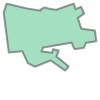

In [6]:
normalized_border

In [7]:

def generate_points(area_to_fill: Polygon | MultiPolygon, radius, seed=None):
    if seed is None:
        seed = np.random.default_rng()

    bbox = area_to_fill.envelope
    min_x, min_y, max_x, max_y = bbox.bounds

    width = max_x - min_x
    height = max_y - min_y

    norm_radius = radius / max(width, height)

    engine = PoissonDisk(d=2, radius=norm_radius, seed=seed)
    points = engine.random(int(bbox.area // (math.pi * radius ** 2)) * 10)

    points[:, 0] = points[:, 0] * width + min_x
    points[:, 1] = points[:, 1] * height + min_y

    points_in_polygon = np.array([point for point in points if area_to_fill.contains(Point(point))])

    return points_in_polygon


poisson_points = generate_points(normalized_border, 0.1)
# m1 = gpd.GeoDataFrame(geometry=[border],crs=local_crs).explore()
# gpd.GeoDataFrame(geometry=points,crs=local_crs).explore(m=m1,color='red')

In [8]:
full_area = normalized_border.area
areas = pd.DataFrame(list(areas_dict.items()), columns=['zone_name', 'ratio'])
areas['ratio'] = areas['ratio'] / areas['ratio'].sum()
areas['area'] = areas['ratio'] * full_area
areas.sort_values(by='ratio', ascending=True, inplace=True)
area_per_site = full_area / (len(poisson_points))
areas['site_indeed'] = round(areas['area'] / area_per_site).astype(int)
zones = np.random.permutation(np.repeat(areas.index, areas['site_indeed']))
poisson_points = poisson_points[:len(zones)]
zones = zones[:len(poisson_points)].astype(int)

In [9]:
normalized_border = [round(item, 8) for sublist in normalized_border.exterior.coords[::-1] for item in sublist]

In [11]:
import rust_optimizer

res = rust_optimizer.optimize_space(vtxl2xy=normalized_border,
                                    site2xy=poisson_points.flatten().round(8).tolist(),
                                    site2room=zones.tolist(),
                                    site2xy2flag=[0.0 for _ in range(len(zones) * 2)],
                                    room2area_trg=areas['area'].sort_index().round(8).tolist(),
                                    room_connections=[(1,2),(1,3)],
                                    create_gif=False
                                    )

In [12]:
from shapely.geometry import Polygon

def denormalize_coords(normalized_coords, bounds):
    minx, miny, maxx, maxy = bounds
    width = maxx - minx
    height = maxy - miny
    scale = max(width, height)

    cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
    denormalized_coords = [
        (
            (x - 0.5) * scale + cx,
            (y - 0.5) * scale + cy
        )
        for x, y in normalized_coords
    ]
    
    return denormalized_coords


In [13]:
from shapely import LineString
from shapely.ops import polygonize, unary_union

normalized_points = [x for x in np.array(res[1]).reshape(int(len(res[1])/2),2)]
new_roads = [denormalize_coords((normalized_points[x[0]],normalized_points[x[1]]),bounds) for x in np.array(res[0]).reshape(int(len(res[0])/2),2)]
new_roads = [LineString(x) for x in new_roads]

roads_w_border = new_roads + [LineString(rotated_bounds.exterior.coords)]

devided_zones = gpd.GeoDataFrame(geometry=list(polygonize((unary_union(roads_w_border).simplify(50)))),crs=local_crs)


In [14]:
centroids = denormalize_coords([x for x  in np.array(res[2]).reshape(int(len(res[2])/2),2)],bounds)
centroids = gpd.GeoDataFrame(data = {'zone':zones},geometry=[Point(x) for x in centroids],crs=local_crs)


In [15]:
devided_zones = devided_zones.sjoin(centroids, how='left').groupby('zone').agg({'geometry':'first'}).reset_index()

In [16]:

devided_zones = devided_zones.merge(areas.reset_index(), left_on='zone', right_on='index').drop(columns=['index','area','site_indeed'])


In [17]:
max_block_size_dict = {'industrial': 500000,
              'residential': 500000,
              'recreation': 400000,
              'business': 200000,
              'agro':400000}
devided_zones = devided_zones.set_geometry('geometry').set_crs(local_crs)
devided_zones['area'] = devided_zones.area
devided_zones['n_split'] = devided_zones.apply(lambda x:x.area//max_block_size_dict.get(x.zone_name),axis=1)
devided_zones

,zone,geometry,zone_name,ratio,area,n_split
0,0,"POLYGON ((331584.866 6583273.443, 331616.07 65...",industrial,0.2,7.983242e+05,1.0
1,1,"POLYGON ((331002.1 6583887.784, 330998.976 658...",residential,0.5,2.189729e+06,4.0
2,2,"POLYGON ((330159.783 6583884.671, 330629.2 658...",recreation,0.1,4.621568e+05,1.0
3,3,"POLYGON ((330173.965 6583536.789, 330641.634 6...",business,0.1,4.250638e+05,2.0
4,4,"POLYGON ((330629.2 6583887.992, 330159.783 658...",agro,0.1,3.032111e+05,0.0


In [19]:
pip install folium matplotlib mapclassify

  Using cached folium-0.18.0-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached mapclassify-2.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached branca-0.8.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached xyzservices-2024.9.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached folium-0.18.0-py2.py3-none-any.whl (108 kB)
Using cached matplotlib-3.9.2-cp311-cp311-win_amd64.whl (7.8 MB)
Using cached mapclassify-2.8.1-py3-none-any

In [20]:
test = devided_zones.set_geometry('geometry').set_crs(local_crs)
test.geometry = test.geometry.rotate(angle, border.centroid, use_radians=True)
test.explore(column='zone_name', cmap='viridis', tiles='CartoDB positron')

In [25]:
devided_zones_splitted=[]

for i,row in devided_zones.iterrows():
    if row.n_split > 1:
        n_split = row.n_split
        
        cur_poly_bounds = row.geometry
        bounds = cur_poly_bounds.bounds
        normalized_border = normalize_polygon(cur_poly_bounds.buffer(5), bounds)
        poisson_points = generate_points(normalized_border, 0.1)
        full_area = normalized_border.area
        
        areas = pd.DataFrame(data=[row.zone_name for _ in range(int(n_split))], columns=['zone_name'])
        areas['area'] = full_area/n_split
        area_per_site = full_area / (len(poisson_points))
        areas['site_indeed'] = round(areas['area'] / area_per_site).astype(int)
        zones = np.random.permutation(np.repeat(areas.index, areas['site_indeed']))
        poisson_points = poisson_points[:len(zones)]
        zones = zones[:len(poisson_points)].astype(int)
        normalized_border = [round(item, 8) for sublist in normalized_border.exterior.coords[::-1] for item in sublist]
        res = rust_optimizer.optimize_space(vtxl2xy=normalized_border,
                                            site2xy=poisson_points.flatten().round(8).tolist(),
                                            site2room=zones.tolist(),
                                            site2xy2flag=[0.0 for _ in range(len(zones) * 2)],
                                            room2area_trg=areas['area'].sort_index().round(8).tolist(),
                                            room_connections=[],
                                            create_gif=False
                                            )
        normalized_points = [x for x in np.array(res[1]).reshape(int(len(res[1])/2),2)]
        new_roads_2 = [denormalize_coords((normalized_points[x[0]],normalized_points[x[1]]),bounds) for x in np.array(res[0]).reshape(int(len(res[0])/2),2)]
        new_roads_2 = [LineString(x) for x in new_roads_2]
        
        roads_w_border_2 = new_roads_2 + [LineString(cur_poly_bounds.exterior.coords)]
        
        devided_zones_inside = gpd.GeoDataFrame(geometry=list(polygonize((unary_union(roads_w_border_2)))),crs=local_crs)
        centroids = denormalize_coords([x for x  in np.array(res[2]).reshape(int(len(res[2])/2),2)],bounds)
        centroids = gpd.GeoDataFrame(data = {'zone':zones},geometry=[Point(x) for x in centroids],crs=local_crs)
        devided_zones_inside = devided_zones_inside.sjoin(centroids, how='left').groupby('zone').agg({'geometry':'first'}).reset_index()
        devided_zones_inside = devided_zones_inside.merge(areas.reset_index(), left_on='zone', right_on='index').drop(columns=['index','area','site_indeed'])
        
        devided_zones_splitted.append(devided_zones_inside)
    else:
        devided_zones_splitted.append(row.to_frame().transpose())


In [26]:
test = pd.concat(devided_zones_splitted,ignore_index=True).set_geometry('geometry').set_crs(local_crs)
test.geometry = test.geometry.rotate(angle,border.centroid,use_radians=True)

In [27]:
test.explore(column='zone_name',cmap='viridis',tiles='CartoDB positron')

In [2]:
from gen_planner.python.src.func_zones import bs

In [5]:
bs.industrial_territory